We are going to see how to build a neural net from scratch, using only numpy.

# Structure

In our structure, we will have three layers: input and hidden layer with 'ReLU' activation function, and the output with 'softmax' activation function to find the most likely (most certain) predicted number. 
We will also using Adam optimizer (more on this part later).
The dataset we will use is "MNIST" - which is a popular dataset of handwritten digits used for training image processing systems. 

In [5]:
# We can initialize layers directly using Layer, or if we want our specific structure - with CreateModel.
import Layer 
import Train 


input_size = 784
hidden_size = [512, 512]
output_size = 10
# option 1:
layer1 = Layer.FullyConnectedLayer(input_size=input_size, output_size=hidden_size[0], activation="relu")
layer2 = Layer.FullyConnectedLayer(input_size=hidden_size[0], output_size=hidden_size[1], activation="relu")
layer3 = Layer.FullyConnectedLayer(input_size=hidden_size[1], output_size=output_size, activation="softmax")

# option 2:
model = Train.CreateModel(input_size, output_size, hidden_size)

# MNIST Dataset
We want to load the MNIST dataset, reshape the images, normalize pixel values, and one-hot encodes the labels. To do so, we will use `Train.load_mnist()`. 
This function loads the MNIST dataset and preprocesses it for use in a neural network model.

After loading the data, we will define the input, hidden, and output shapes for the neural network and preprocesses the test data similarly to the training data. This sets up the data for training and evaluating a neural network.

##### Train.load_MNIST()
1. **Loading Data**: From TensorFlow.keras.mnist datasets and split it to train\test.
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train and X_test contain the images of the digits, and Y_train and Y_test contain the corresponding labels (the digits themselves).
   
2. **Reshaping the Images**:
    'X_train = X_train.reshape((60000, 784))'
   Reshapes the training images from their original 28x28 pixel format into a flat vector of 784 pixels (28x28 = 784). This makes it easier to feed into a neural network.
3. **Normalizing the Data:**
    `X_train = X_train.astype("float32") / 255.0` Converts the pixel values to floats and normalizes them to a range of 0 to 1. This step helps in speeding up the training and ensures that the model converges more effectively.
4. **One-Hot Encoding the Labels:**
    `Y_train = to_categorical(Y_train)` Converts the labels (which are integers from 0 to 9) into one-hot encoded vectors. For example, the digit 3 would be represented as [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

5. **Return Values:** The function returns the processed X_train, Y_train, X_test, and Y_test.

In [6]:
x_train, y_train, x_test, y_test = Train.load_mnist()

After loading the data, we need to define the input, hidden, and output shapes for the neural network and preprocesses the test data similarly to the training data. This sets up the data for training and evaluating a neural network.

In [7]:
from tensorflow.keras.utils import to_categorical

input_shape = 784
hidden_shape = [512, 512]
output_shape = 10
x_test = x_test.reshape((x_test.shape[0], -1)) # Flattens the test images similarly to how the training images were flattened.
y_test = to_categorical(y_test, num_classes=output_shape) # One-hot encodes the test labels.

### What Is Adam Optimizer?
First, an optimizer is a method that adjusts the weights of a neural network to minimize the loss (the difference between the predicted output and the actual output). The goal is to find the best set of weights that allow the model to make accurate predictions.

**Adam** stands for 'Adaptive Moment Estimation'. It's an extension of the Stochastic Gradient Descent (SGD) optimizer, but it improves on it by adapting the learning rate individually for each parameter


#### **How Does Adam Work?**
1. **Learning Rate:** The rate at which the optimizer adjusts the weights. Adam adjusts this rate automatically for each weight, which helps in faster convergence.
2. **Moment Estimates**:
    - **First Moment (Mean of Gradients, `m`):** Adam keeps track of the average of the gradients (the direction and magnitude of how much each weight should change).
    - **Second Moment (Variance of Gradients, v):** Adam also tracks the squared gradients, which helps it understand how much variation or "noise" there is in the gradient updates.
3. **Bias Correction:** Adam adjusts these moment estimates so that they are unbiased, especially at the beginning of training when the estimates might not be very accurate.
4. **Update Rule**: After calculating the corrected m and v, Adam updates the weights by considering both the direction (m) and the stability (v) of the updates.


# Quick Review On FullyConnectedLayer Initialization
In this class, we will have all the parameter for updating $w,b$ during the training process.
Let's define the initialization (`__init__`) for a custom layer or a neural network component, with various parameters like weights, biases, and hyperparameters are initialized.

1. **Parameters**:
   - `input_size`: This specifies the number of input features to the layer.
   - `output_size`: This defines the number of neurons or units in the layer, i.e., the output dimension.
   - `activation`: The activation function to be used in the layer (e.g., 'relu', 'sigmoid').

2. **Activation Function**:
   - `self.activation = activation`: This stores the activation function as an instance variable for later use during the forward pass.

3. **Weights and Biases Initialization**:
   - `self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)`: This initializes the weights using a Gaussian distribution (normal distribution) with mean 0 and variance 1, scaled by $\(\sqrt{\frac 2 \text{input size}}\)$. This scaling follows the He initialization method, commonly used for layers with ReLU activation functions to maintain a good gradient flow during backpropagation.
   - `self.biases = np.zeros((1, output_size))`: This initializes the biases as a zero vector of shape `(1, output_size)`.

4. **Adam Optimizer Parameters**:
   - **Moment Estimates**:
     - `self.m_weights = np.zeros((input_size, output_size))`: Initializes the first moment estimate (mean of gradients) for weights as zeros.
     - `self.v_weights = np.zeros((input_size, output_size))`: Initializes the second moment estimate (uncentered variance of gradients) for weights as zeros.
     - `self.m_biases = np.zeros((1, output_size))`: Initializes the first moment estimate for biases as zeros.
     - `self.v_biases = np.zeros((1, output_size))`: Initializes the second moment estimate for biases as zeros.
   - **Hyperparameters**:
     - `self.beta1 = 0.9`: This is the exponential decay rate for the first moment estimate in the Adam optimizer.
     - `self.beta2 = 0.999`: This is the exponential decay rate for the second moment estimate in the Adam optimizer.
     - `self.offset = 1e-8`: This small constant is added to the denominator to improve numerical stability and prevent division by zero in the Adam update rule.

Now, we have the structure and we can start the training process.
## Train 
The `train` method is designed to train the neural network using a process called gradient descent over a specified number of epochs. It involves forward propagation, loss and accuracy calculation, and backpropagation to update the model's weights.


### **Training Process:**
1. **Initialization**:
   - `time = 0`: This variable is initialized to keep track of the number of training iterations.
   - `loss_log = []`,`accuracy_log = []`: These lists are initialized to store the loss and accuracy values for each epoch, which can be used for analysis or plotting later.

2. **Epoch Loop**:
   - The training process runs for `n_epochs`, meaning it will iterate through the dataset multiple times.

   **Inside Each Epoch**:
   - **Forward Propagation**:
     - `output = self.forward(inputs=inputs)`: The input data is passed through the network to generate predictions (=outputs). The `forward` method computes the activations of each layer.
   
   - **Loss Calculation**:
     - `loss = Utils.calculate_loss_crossentropy(output, targets)`: The cross-entropy loss between the predicted output and the actual targets is calculated.

   - **Accuracy Calculation**:
     - `accuracy = Utils.accuracy(output, targets)`: The accuracy of the model's predictions is calculated by comparing the predicted labels with the actual labels.

   - **Backpropagation**:
     - `self.backward(decay, epoch, initial_learning_rate, output, targets, time)`: The backpropagation process updates the network's weights. It uses the calculated gradients from the loss to adjust the weights in the direction that minimizes the loss. 
     - **Learning Rate Decay**: The learning rate may be adjusted based on the `decay` factor and the current epoch.
   
   - **Time Update**:
     - `time += 1`: The time variable is incremented after each epoch to keep track of the total iterations.

Epoch 0 - Loss: 0.2415337401309688 - Accuracy: 0.10798333333333333


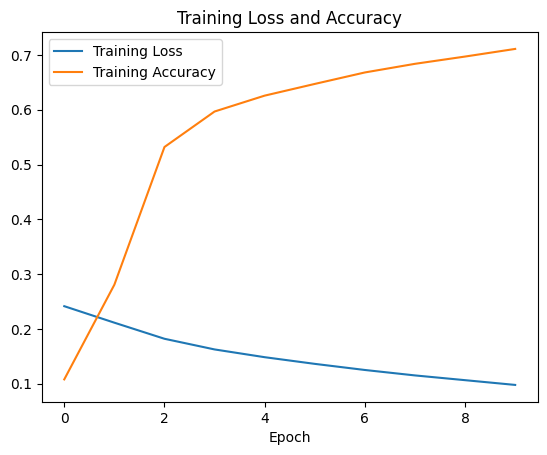

In [8]:
model.train(x_train, y_train, initial_learning_rate=0.001, decay=0.001, n_epochs=10, plot_training_results=True)

Now, you can run the previous cell and watch it gets better every time. We will do it once in the next cell, so you can observe the differences.

Epoch 0 - Loss: 0.0878440793540021 - Accuracy: 0.7396333333333334


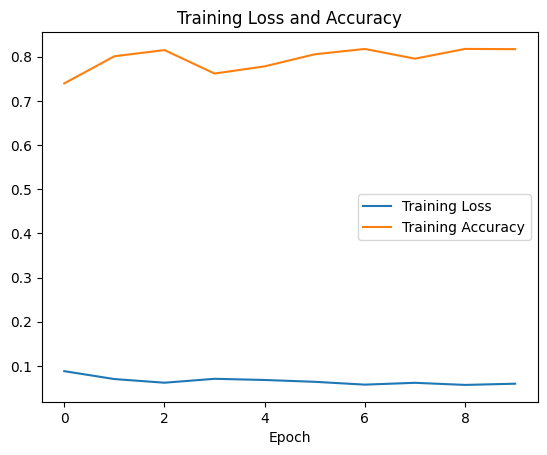

In [9]:
model.train(x_train, y_train, initial_learning_rate=0.001, decay=0.001, n_epochs=10, plot_training_results=True)

The training process contains a "forward propagation" and "backpropagation". 


`forward` method computes the output of the layer when given an input. This is the process where data passes through the network from input to output, making predictions.
Its basically calculating $z=\left\langle x,w\right\rangle +b$ where $w$ are the weights, $x$ are the input values, and $b$ is the bias term,
and then passed $z$ through an activation function to introduce non-linearity into the model $a = \varphi(z)$, where $\varphi$ is the activation function. 

`backward` method calculates gradients for the weights and biases based on the error and updates the weights and biases using these gradients. The method also calculates the gradient with respect to the input to continue the backpropagation process through the network. 


### Backpropagation Pseudocode

In [11]:
"""
# Given:
 - A neural network with L layers. 
 - Input X and corresponding target Y.
 - Learning rate "eta".

# Step 1: Perform forward pass
For each layer l in 1 to L:
    Calculate Z[l] = W[l] * A[l-1] + b[l]   # Z is the linear combination of inputs and weights plus bias
    Apply activation function to get A[l] = Activation(Z[l])  # A is the activation output
 # After the forward pass, A[L] is the output of the network

# Step 2: Compute the loss
Compute the loss: Loss = LossFunction(Y, A[L])

# Step 3: Perform backward pass (Backpropagation)
Initialize dA[L] as the derivative of the loss with respect to A[L]:
    dA[L] = - (Y / A[L]) + ((1 - Y) / (1 - A[L]))  # Example for binary cross-entropy loss

# Backpropagation through layers
For each layer l in L to 1 (backwards):
    dZ[l] = dA[l] * ActivationDerivative(Z[l])  # Calculate dZ for layer l

    dW[l] = (1/m) * dZ[l] * A[l-1].T  # Calculate the gradient of W[l]
    db[l] = (1/m) * sum(dZ[l])        # Calculate the gradient of b[l]

    if l > 1:
        dA[l-1] = W[l].T * dZ[l]  # Propagate the error backwards to the previous layer

    # Step 4: Update the parameters
    W[l] = W[l] - eta * dW[l]  # Update weights
    b[l] = b[l] - eta * db[l]  # Update biases
# End of the backpropagation algorithm 
"""

'\n# Given:\n - A neural network with L layers. \n - Input X and corresponding target Y.\n - Learning rate $\\eta$ (eta).\n\n# Step 1: Perform forward pass\nFor each layer l in 1 to L:\n    Calculate Z[l] = W[l] * A[l-1] + b[l]   # Z is the linear combination of inputs and weights plus bias\n    Apply activation function to get A[l] = Activation(Z[l])  # A is the activation output\n # After the forward pass, A[L] is the output of the network\n\n# Step 2: Compute the loss\nCompute the loss: Loss = LossFunction(Y, A[L])\n\n# Step 3: Perform backward pass (Backpropagation)\nInitialize dA[L] as the derivative of the loss with respect to A[L]:\n    dA[L] = - (Y / A[L]) + ((1 - Y) / (1 - A[L]))  # Example for binary cross-entropy loss\n\n# Backpropagation through layers\nFor each layer l in L to 1 (backwards):\n    dZ[l] = dA[l] * ActivationDerivative(Z[l])  # Calculate dZ for layer l\n\n    dW[l] = (1/m) * dZ[l] * A[l-1].T  # Calculate the gradient of W[l]\n    db[l] = (1/m) * sum(dZ[l])   

In our implementation, `Train.backward` method calculates `Layer.backward` for each layer in composition, and updates the decay factor each time.
     
        time += 1
        learning_rate = initial_learning_rate / (1 + decay * epoch)

Epoch 0 - Loss: 0.05567883053492727 - Accuracy: 0.8211166666666667
Epoch 10 - Loss: 0.04413589321682232 - Accuracy: 0.8597833333333333
Epoch 20 - Loss: 0.04200718104256685 - Accuracy: 0.86595
Epoch 30 - Loss: 0.04045021569429501 - Accuracy: 0.8704833333333334
Epoch 40 - Loss: 0.03901159178306846 - Accuracy: 0.87495


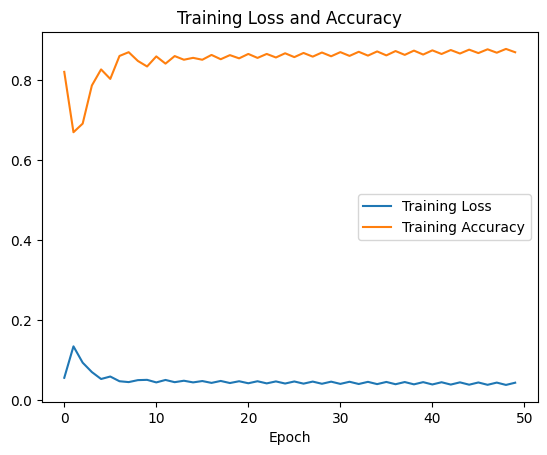

Test Loss: 0.25963677697301984
Test Accuracy: 0.8842


In [12]:
model.train(x_train, y_train, initial_learning_rate=0.001, decay=0.001, n_epochs=50, plot_training_results=True)
print("Test Loss:", model.test_loss(x_test, y_test))
print("Test Accuracy:", model.test_accuracy(x_test, y_test))